# Predicción de Satisfacción con la Carrera

En este cuaderno, exploraremos un conjunto de datos que contiene información sobre estudiantes universitarios, con el objetivo de predecir su satisfacción con su carrera basada en varios factores demográficos y académicos.

### Resumen del Conjunto de Datos:
El conjunto de datos incluye detalles recopilados de estudiantes universitarios a través de un formulario de Google, abarcando una amplia gama de atributos como cursos de certificación completados, género, departamento, rendimiento académico, pasatiempos, hábitos de estudio, expectativas salariales y más. Nuestra variable objetivo de interés es "Do you like your degree?", indicando si a los estudiantes les gusta su carrera o no.

### Tipo de Problema:
Este es un problema de clasificación binaria, ya que nuestro objetivo es predecir si a un estudiante le gusta su carrera (clase positiva) o no (clase negativa) basado en las características disponibles. Entrenaremos modelos de aprendizaje automático utilizando los datos proporcionados para predecir la probabilidad de satisfacción con la carrera de un estudiante.

## Resumen:

0. Carga de librerías necesarias y datos
1. Análisis preliminar de los datos y preparación de los mismos
2. Elección de la métrica
3. Ajuste y selección de algoritmos y sus parámetros
4. Evaluación de algoritmos
5. Conclusiones

## 0. Carga de librerías necesarias y datos

In [53]:
import pandas as pd
import numpy as np
import missingno as msno

from sklearn.model_selection import RandomizedSearchCV, cross_val_score, train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, label_binarize

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from ydata_profiling import ProfileReport

from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [54]:
# Carga del dataset
df = pd.read_csv('Student Attitude and Behavior.csv')

#Crear copia del dataframe
df_copy = df.copy()

# Comprobar el dataset, primeros valores
df_copy.head()

,Certification Course,Gender,Department,Height(CM),Weight(KG),10th Mark,12th Mark,college mark,hobbies,daily studing time,prefer to study in,salary expectation,Do you like your degree?,willingness to pursue a career based on their degree,social medai & video,Travelling Time,Stress Level,Financial Status,part-time job
0,No,Male,BCA,100.0,58.0,79.0,64.0,80.0,Video Games,0 - 30 minute,Morning,40000,No,50%,1.30 - 2 hour,30 - 60 minutes,Bad,Bad,No
1,No,Female,BCA,90.0,40.0,70.0,80.0,70.0,Cinema,30 - 60 minute,Morning,15000,Yes,75%,1 - 1.30 hour,0 - 30 minutes,Bad,Bad,No
2,Yes,Male,BCA,159.0,78.0,71.0,61.0,55.0,Cinema,1 - 2 Hour,Anytime,13000,Yes,50%,More than 2 hour,30 - 60 minutes,Awful,Bad,No
3,Yes,Female,BCA,147.0,20.0,70.0,59.0,58.0,Reading books,1 - 2 Hour,Anytime,1500000,No,50%,1.30 - 2 hour,0 - 30 minutes,Bad,good,No
4,No,Male,BCA,170.0,54.0,40.0,65.0,30.0,Video Games,30 - 60 minute,Morning,50000,Yes,25%,1.30 - 2 hour,30 - 60 minutes,Good,good,No


## 1. Análisis preliminar de los datos y preparación de los mismos

Empezamos renombrando todas las variables del dataset ya que estaban o mal escritas o no tenían nombres prácticos.

In [55]:
df_copy.rename(columns={'Certification Course': 'cert_course',
                   'Gender':'gender',
                   'Department':'department',
                   'Height(CM)':'height',
                   'Weight(KG)':'weight',
                   '10th Mark':'mark10',
                   '12th Mark': 'mark12',
                   'college mark':'college_mark',
                   'daily studing time':'daily_study',
                   'prefer to study in':'prefer_study',
                   'salary expectation': 'expected_salary',
                   'Do you like your degree?':'degree_satisfaction',
                   'willingness to pursue a career based on their degree  ':'willingness_career',
                   'social medai & video': 'social_media&video',
                   'Travelling Time ':'travelling_time',
                   'Stress Level ':'stress_level',
                   'Financial Status':'financial_status',
                   'part-time job':'part_time_job'},inplace=True)

MÉTODO AUTOMÁTICO

In [49]:
# Cambiar las columnas a snake case column names to snake case
df_copy.columns = df_copy.columns.str.lower()
df_copy.columns = df_copy.columns.str.replace(' ', '_')

# Print the new column names
df_copy.columns

Index(['certification_course', 'gender', 'department', 'height(cm)',
       'weight(kg)', '10th_mark', '12th_mark', 'college_mark', 'hobbies',
       'daily_studing_time', 'prefer_to_study_in', 'salary_expectation',
       'do_you_like_your_degree?',
       'willingness_to_pursue_a_career_based_on_their_degree__',
       'social_medai_&_video', 'travelling_time_', 'stress_level_',
       'financial_status', 'part-time_job'],
      dtype='object')

In [56]:
# Obtención de la información del dataset
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235 entries, 0 to 234
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   cert_course          235 non-null    object 
 1   gender               235 non-null    object 
 2   department           235 non-null    object 
 3   height               235 non-null    float64
 4   weight               235 non-null    float64
 5   mark10               235 non-null    float64
 6   mark12               235 non-null    float64
 7   college_mark         235 non-null    float64
 8   hobbies              235 non-null    object 
 9   daily_study          235 non-null    object 
 10  prefer_study         235 non-null    object 
 11  expected_salary      235 non-null    int64  
 12  degree_satisfaction  235 non-null    object 
 13  willingness_career   235 non-null    object 
 14  social_media&video   235 non-null    object 
 15  travelling_time      235 non-null    obj

En este caso no tenemos ningún valor falante por lo que no tenemos que aplicar ningún método de imputación de datos.

<Axes: >

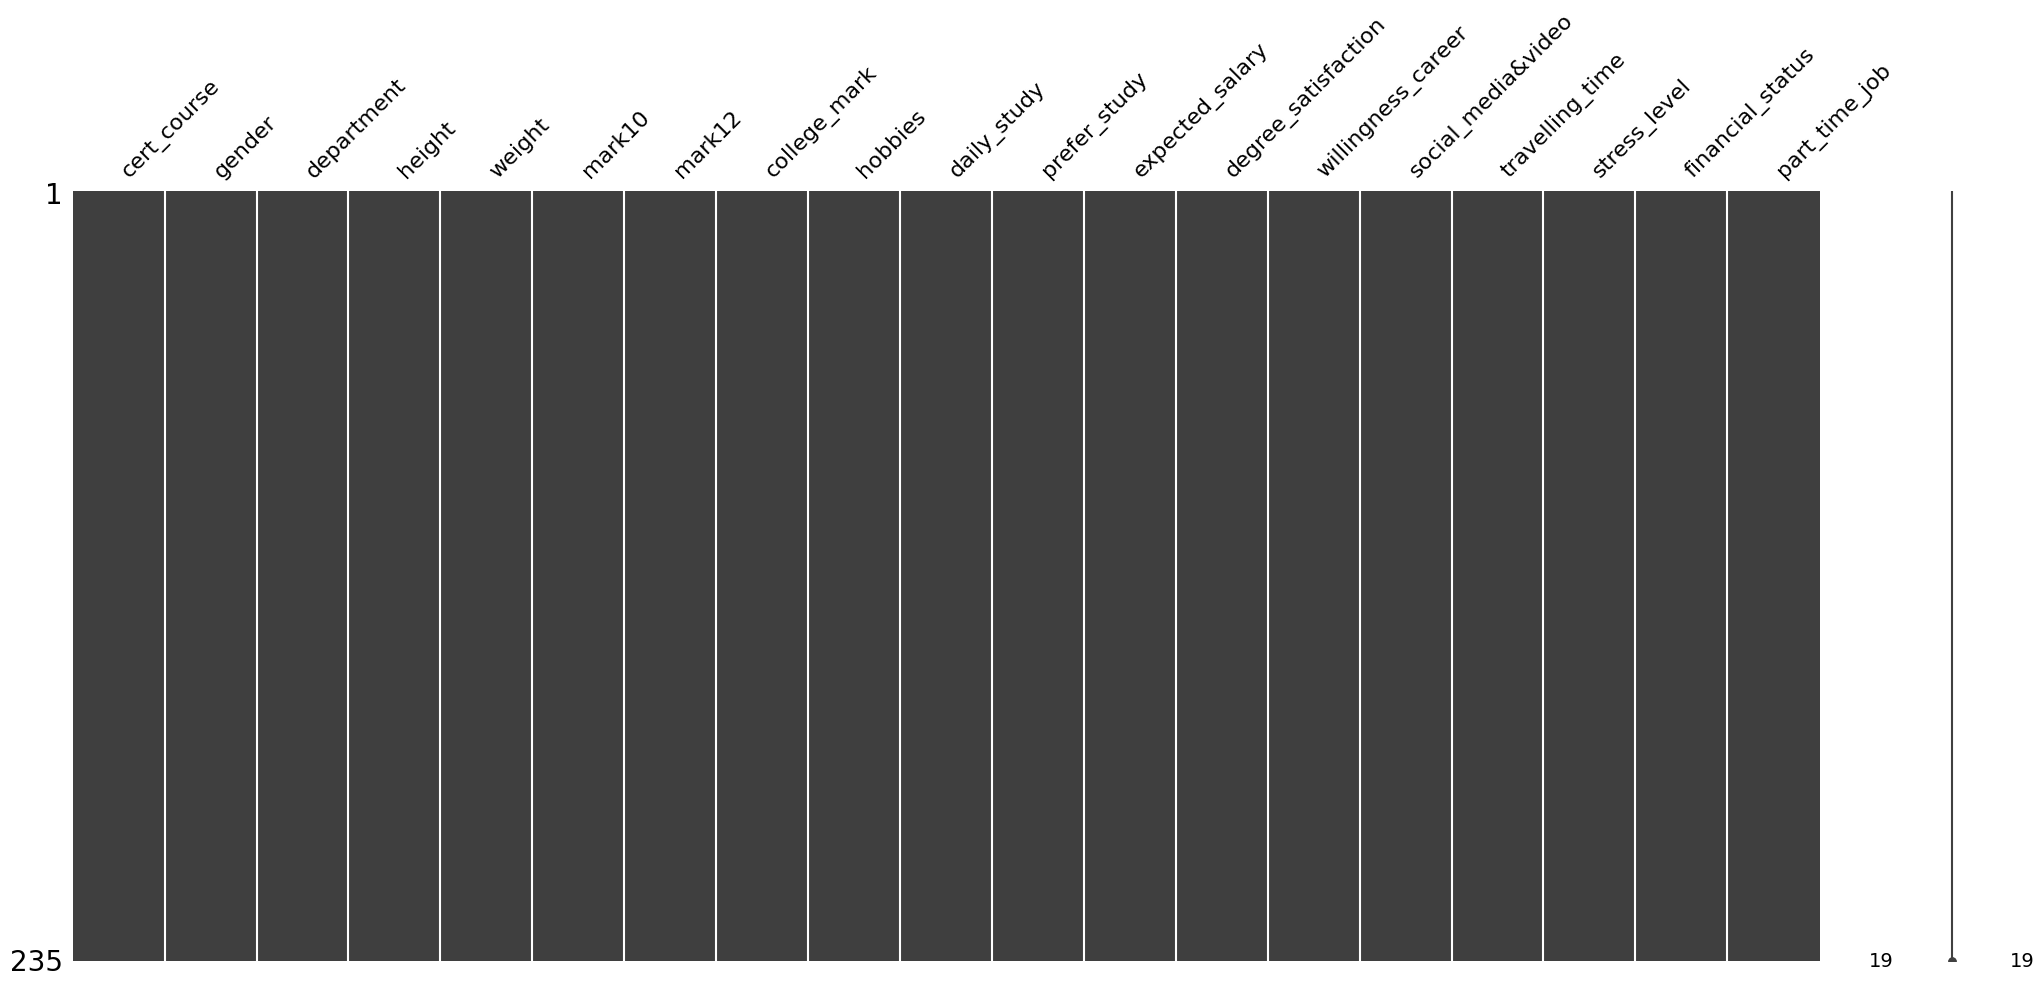

In [57]:
# Visualizar los valores que faltan
msno.matrix(df_copy)

report = ProfileReport(df_copy, minimal=False)
report

Cambiamos las variables categóricas que aparecen como tipo object a category

In [58]:
# Seleccionar columnas que aparecen como object y sabemos que son category
object_cols = ['cert_course', 'gender', 'department', 'hobbies', 'daily_study',
       'prefer_study', 'degree_satisfaction', 'willingness_career',
       'social_media&video', 'travelling_time', 'stress_level',
       'financial_status', 'part_time_job']

In [59]:
# Convertimos en category
df_copy[object_cols]=df_copy[object_cols].astype('category')

# Comprobamos el cambio
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235 entries, 0 to 234
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   cert_course          235 non-null    category
 1   gender               235 non-null    category
 2   department           235 non-null    category
 3   height               235 non-null    float64 
 4   weight               235 non-null    float64 
 5   mark10               235 non-null    float64 
 6   mark12               235 non-null    float64 
 7   college_mark         235 non-null    float64 
 8   hobbies              235 non-null    category
 9   daily_study          235 non-null    category
 10  prefer_study         235 non-null    category
 11  expected_salary      235 non-null    int64   
 12  degree_satisfaction  235 non-null    category
 13  willingness_career   235 non-null    category
 14  social_media&video   235 non-null    category
 15  travelling_time      23

Aquí ya nos damos cuenta de que la variable objetivo está muy desbalanceada y vamos a tener que arreglarlo de alguna forma. Más adelante aplicamos el resampleado para que los valores estén balanceados.

In [60]:
df_copy['degree_satisfaction'].value_counts()

degree_satisfaction
Yes    215
No      20
Name: count, dtype: int64

En los reports vemos que hay outliers en las variables numéricas y pasamos a eliminarlos para reducir ruido y aumentar precisión.

In [61]:
# Columnas específicas para eliminar outliers
columnas = ['height', 'weight', 'mark12','mark10','college_mark','expected_salary']

# Definir cuartiles y calcular IQR solo para las columnas específicas
Q1 = df_copy[columnas].quantile(0.25)
Q3 = df_copy[columnas].quantile(0.75)
IQR = Q3 - Q1

# Definir máscara para filtrar outliers solo en las columnas específicas
mask = ~((df_copy[columnas] < (Q1 - 1.5 * IQR)) | (df_copy[columnas] > (Q3 + 1.5 * IQR))).any(axis=1)

# Quitar outliers solo en las columnas específicas
df_no_outliers = df_copy[mask]


report = ProfileReport(df_no_outliers, minimal=False)
report

In [62]:
# Copia del dataset antes de seguir transformandolo
df_copy_2 = df_no_outliers.copy()

# One-hot encoding para variables categoricas cuidado con no meter la variable objetivo
df_dummies = pd.get_dummies(df_copy_2, columns=['cert_course', 'gender', 'department', 'hobbies', 'daily_study',
       'prefer_study', 'willingness_career',
       'social_media&video', 'travelling_time', 'stress_level',
       'financial_status', 'part_time_job'], drop_first=True, prefix=['cert_course', 'gender', 'department', 'hobbies', 'daily_study',
       'prefer_study', 'willingness_career',
       'social_media&video', 'travelling_time', 'stress_level',
       'financial_status', 'part_time_job'], dtype='int64')


# Concatenar el dataframe original y el de dummies the original 
df_copy_2 = pd.concat([df_copy_2, df_dummies], axis=1)

# Eliminar variables dummy
df_copy_2 = df_copy_2.drop(columns=['cert_course', 'gender', 'department', 'hobbies', 'daily_study',
       'prefer_study', 'willingness_career',
       'social_media&video', 'travelling_time', 'stress_level',
       'financial_status', 'part_time_job'])

# Eliminar duplicados de columnas 
df_copy_2 = df_copy_2.loc[:,~df_copy_2.columns.duplicated()]
# Reset the index and drop the previous index
df_copy_2 = df_copy_2.reset_index(drop=True)

# Crear e imprimir un informe a partir de los datos con el tipo de dato correcto.
report = ProfileReport(df_copy_2, minimal=False)
report

Con el report vemos que hay muchas variables dummies que podemos quitar ya que están muy desbalanceadas y solo generarán ruido. 

HACER ESTO O CON RFECV MÁS ABAJO

In [12]:
df_copy_2.drop(columns=['department_B.com ISM', 'hobbies_Reading books','hobbies_Video Games','daily_study_2 - 3 hour',
                        'daily_study_3 - 4 hour','daily_study_More Than 4 hour','prefer_study_Night','willingness_career_100%',
                        'willingness_career_25%','social_media&video_1 - 30 Minute','social_media&video_1.30 - 2 hour',
                        'social_media&video_More than 2 hour','travelling_time_1 - 1.30 hour','travelling_time_1.30 - 2 hour',
                        'travelling_time_2 - 2.30 hour','travelling_time_2.30 - 3 hour', 'travelling_time_more than 3 hour',
                        'stress_level_fabulous','financial_status_Fabulous','part_time_job_Yes','social_media&video_1 - 1.30 hour',
                        'willingness_career_50%','daily_study_1 - 2 Hour'], inplace=True)

In [63]:
# Eliminar las filas duplicadas
df_copy_2 = df_copy_2.drop_duplicates()

report = ProfileReport(df_copy_2, minimal=False)
report

Convertimos los valores 1 y 0 a Yes y No respectivamente, para que los algoritmos puedan calcular el accuracy ya que necesita valores númericos

In [64]:

df_copy_2['degree_satisfaction'] = df_copy_2['degree_satisfaction'].replace({'Yes': 1, 'No': 0})


Comprobamos que se han cambiado correctamente los valores.

In [65]:
df_copy_2['degree_satisfaction'].value_counts()

degree_satisfaction
1    179
0     12
Name: count, dtype: int64

In [66]:
# Hacemos una copia al dataset antes de seguir modificando cosas
df_copy_2

,height,weight,mark10,mark12,college_mark,expected_salary,degree_satisfaction,cert_course_Yes,gender_Male,department_B.com ISM,...,travelling_time_2.30 - 3 hour,travelling_time_30 - 60 minutes,travelling_time_more than 3 hour,stress_level_Bad,stress_level_Good,stress_level_fabulous,financial_status_Bad,financial_status_Fabulous,financial_status_good,part_time_job_Yes
0,159.0,78.0,71.0,61.00,55.0,13000,1,1,1,0,...,0,1,0,0,0,0,1,0,0,0
1,139.0,33.0,90.0,75.00,70.0,20000,1,1,0,0,...,0,0,0,1,0,0,0,0,1,0
2,152.0,43.0,61.6,61.67,75.0,25000,1,0,1,0,...,0,0,0,0,1,0,0,0,1,0
3,190.0,85.0,88.2,67.50,60.0,20000,1,0,1,0,...,0,0,0,1,0,0,1,0,0,0
4,150.0,84.0,60.0,65.00,70.0,20000,1,0,1,0,...,0,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,153.0,60.0,60.0,70.00,70.0,15000,1,0,0,1,...,0,0,0,0,1,0,1,0,0,0
187,170.0,76.0,72.0,67.00,65.0,7000,1,1,1,1,...,0,1,0,1,0,0,1,0,0,0
188,172.0,52.0,72.0,70.00,76.0,25000,1,1,1,1,...,0,1,0,0,1,0,0,0,1,0
189,139.0,33.0,90.0,75.00,70.0,20000,1,1,0,0,...,1,0,0,1,0,0,0,0,1,0


## 2. Elección de la métrica
Optaremos por la métrica de precisión (accuracy) para evaluar nuestro modelo de predicción de la variable "Do you like your degree?". La precisión es una medida directa de la proporción de predicciones correctas realizadas por el modelo sobre el total de predicciones realizadas. Elegimos accuracy ya que proporciona una medida clara y fácilmente interpretable del rendimiento del modelo en la predicción de la variable objetivo "Do you like your degree?".

## 3. Ajuste y selección de algoritmos y sus parámetros

Antes de hacer el split de train y test, aplicamos una transformación de remuestreo debido a que nuestra variable objetivo tiene un gran desbalance como ya vimos anteriormente.

Se realiza la separación de los features y la variable objetivo, para poder separar el dataset en train y test. Se separan en train y test.

Dividimos el conjunto de datos en los conjuntos de entrenamiento y prueba siguiendo un tamaño de prueba del 30% y teniendo degree_satisfaction como la variable dependiente

In [67]:
from imblearn.combine import SMOTEENN

# Separación de las features y la variable objetivo
X = df_copy_2.drop(columns=['degree_satisfaction'])
y = df_copy_2['degree_satisfaction']

# Crear una instancia de SMOTEENN
smote_enn = SMOTEENN(random_state=42)

# Aplicar la transformación de remuestreo a los datos de entrenamiento
X, y = smote_enn.fit_resample(X, y)


In [68]:
# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y,shuffle=True)

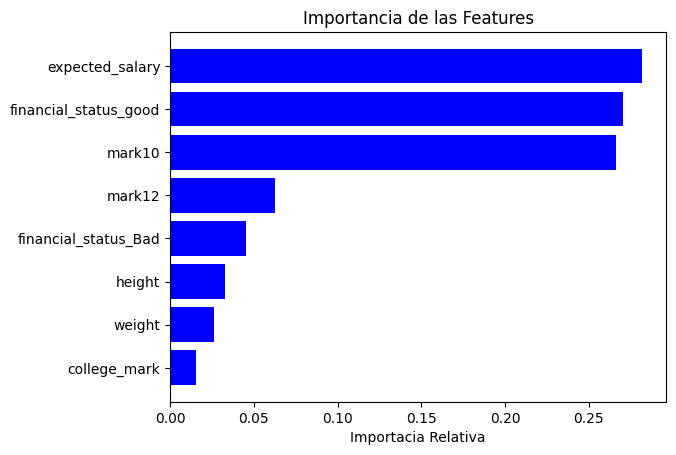

In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

# Definir el estimador y el método de validación cruzada
estimator = RandomForestRegressor(random_state=42)
cv = KFold(n_splits=5)

# Definir el método RFECV
rfecv = RFECV(estimator, step=1, cv=cv, scoring="neg_mean_squared_error")

# Ajustar el método RFECV al dataset
rfecv.fit(X_train, y_train)

# Importancia de las features
importances = rfecv.estimator_.feature_importances_

# Nombres de las features
feature_names = X_train.columns[rfecv.support_]

# Orderar por importancia
indices = np.argsort(importances)

plt.title('Importancia de las Features')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Importacia Relativa')
plt.show()

Ahora seria eliminar todas las columnas que no estuvieran aquí de df_copy_2 y volver a hacer el split

In [37]:
df_copy_2.drop(columns=['department_B.com ISM', 'hobbies_Reading books','hobbies_Video Games','daily_study_2 - 3 hour',
                        'daily_study_3 - 4 hour','daily_study_More Than 4 hour','prefer_study_Night','willingness_career_100%',
                        'willingness_career_25%','social_media&video_1 - 30 Minute','social_media&video_1.30 - 2 hour',
                        'social_media&video_More than 2 hour','travelling_time_1 - 1.30 hour','travelling_time_1.30 - 2 hour',
                        'travelling_time_2 - 2.30 hour','travelling_time_2.30 - 3 hour', 'travelling_time_more than 3 hour',
                        'stress_level_fabulous','financial_status_Fabulous','part_time_job_Yes','social_media&video_1 - 1.30 hour',
                        'willingness_career_50%','daily_study_1 - 2 Hour'], inplace=True)

In [38]:
from imblearn.combine import SMOTEENN

# Separación de las features y la variable objetivo
X = df_copy_2.drop(columns=['degree_satisfaction'])
y = df_copy_2['degree_satisfaction']

# Crear una instancia de SMOTEENN
smote_enn = SMOTEENN(random_state=42)

# Aplicar la transformación de remuestreo a los datos de entrenamiento
X, y = smote_enn.fit_resample(X, y)

In [ ]:
# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y,shuffle=True)

En las dos siguientes celdas podemos comprobar cómo ya está balanceada nuestra variable objetivo 

In [21]:
y.unique()

[0, 1]
Categories (2, int64): [0, 1]

In [26]:
y_train.value_counts()

degree_satisfaction
0    102
1     87
Name: count, dtype: int64

Se procede al escalado de los datos entrenando del modelo de escalado en el train set y se aplica en el test set. Es importante entrenarlo en el train set y no en todo el dataset para evitar data leakage.

In [18]:
# Estandarización de los datos
scaler = StandardScaler()
# Ajuste y transformación de los datos de entrenamiento
X_train_scaled = scaler.fit_transform(X_train)
# Transformación de los datos de prueba
X_test_scaled = scaler.transform(X_test)

Instanciamos todos los modelos para más adelante comparar resultados y seleccionar el mejor modelo.

In [19]:
# Instanciar los modelos
logreg = LogisticRegression(solver='liblinear')
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier(random_state=42)
nb = GaussianNB()
svm = SVC(random_state=42, probability=True)

# Algoritmos Ensenmble
rf = RandomForestClassifier(random_state=42)

# Algoritmos Boosting
ada = AdaBoostClassifier(random_state=42, algorithm='SAMME')
rf = RandomForestClassifier(random_state=42)
ada_rf = AdaBoostClassifier(estimator=rf, algorithm='SAMME')
xgb = XGBClassifier(random_state=42, objective='binary:logistic')
gbc = GradientBoostingClassifier(random_state=42)

estimators = [('Logistic Regression', logreg)
              , ('KNN', knn)
              , ('Random Forest', rf)
              , ('SVM', svm)
              ]

stacking = StackingClassifier(estimators=estimators
                              , final_estimator=LogisticRegression()
                              , cv=StratifiedKFold(n_splits=5))


# Crear la lista de modelos para su evaluación y selección
models = [('Logistic Regression', logreg)
          , ('KNN', knn)
          , ('Decision Tree', dt)
          , ('Random Forest', rf)
          , ('SVM', svm)
          , ('AdaBoost', ada)
          , ('AdaBoost + RF', ada_rf)
          , ('XGBoost', xgb)
          , ('Gradient Boosting', gbc)
          , ('Stacking', stacking)
          ]

Ajuste de parámetros de los algoritmos: 

Se definen los valores iniciales a explorar para hacer el gridsearch en cada uno de los algoritmos.

In [20]:
# Definir los parámetros para la búsqueda de hiperparámetros
logreg_params = {'C': np.logspace(0, 4, 7)}
knn_params = {'n_neighbors': list(range(5, 55))
              , 'weights': ['distance']}
dt_params = {'max_depth': list(range(1, 11))
             , 'criterion': ['gini', 'entropy']}
rf_params = {'n_estimators': [10, 50, 100, 200]
             , 'max_depth': list(range(1, 11))
             , 'criterion': ['gini', 'entropy']
             , 'bootstrap': [True, False]}
svm_params = {'C': np.logspace(-3, 3, 7)
              , 'gamma': np.logspace(-3, 3, 7)
              , 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
ada_params = {'n_estimators': range(500, 800, 50)
              , 'learning_rate': [i * 0.1 for i in range(1, 10)]}
ada_rf_params = {'learning_rate': [i * 0.1 for i in range(1, 10)]}
xgb_params = {'n_estimators': range(50, 100, 10)
              , 'learning_rate': np.logspace(-3, 0, 7)
              , 'max_depth': range(3, 7)
              , 'gamma': [i * 0.1 for i in range(1, 2)]
              , 'subsample': [0.8, 0.9, 1]
              , 'colsample_bytree': [0.8, 0.9, 1]
              , 'objective': ['binary:logistic']
              }
gbc_params = {'n_estimators': range(100, 200, 10)
              , 'learning_rate': np.logspace(-3, 0, 7)}

stacking_params = {'final_estimator__C': np.logspace(0, 4, 7)}

params = [logreg_params
          , knn_params
          , dt_params
          , rf_params,svm_params
          , ada_params
          , ada_rf_params
          , xgb_params
          , gbc_params
          , stacking_params
          ]

Se realiza una búsqueda (RandomizedSearch) con todas las combinaciones de parámetros introducidas para cada uno de los algoritmos.

In [22]:
# Randomized Search para encontrar los mejores hiperparámetros
best_models = {}

for name, model, params in zip([name for name, _ in models]
                               , [model for _, model in models]
                               , params
                               ):
    gs = RandomizedSearchCV(estimator=model
                      , param_distributions=params
                      , cv=StratifiedKFold(5)
                      , scoring='accuracy'
                      , n_jobs=-1)
    
    gs.fit(X_train_scaled, y_train)
    best_models[name] = gs.best_estimator_
    print(f"{name} best params: {gs.best_params_}, best score: {gs.best_score_}")

Logistic Regression best params: {'C': 1.0}, best score: 0.9630156472261735
KNN best params: {'weights': 'distance', 'n_neighbors': 9}, best score: 0.8095305832147937
Decision Tree best params: {'max_depth': 4, 'criterion': 'gini'}, best score: 0.9473684210526315
Random Forest best params: {'n_estimators': 100, 'max_depth': 9, 'criterion': 'entropy', 'bootstrap': True}, best score: 0.9842105263157894
SVM best params: {'kernel': 'linear', 'gamma': 0.001, 'C': 0.1}, best score: 0.9577524893314366
AdaBoost best params: {'n_estimators': 500, 'learning_rate': 0.9}, best score: 0.9682788051209105
AdaBoost + RF best params: {'learning_rate': 0.5}, best score: 0.9842105263157894
XGBoost best params: {'subsample': 0.8, 'objective': 'binary:logistic', 'n_estimators': 70, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 1}, best score: 0.9736842105263157
Gradient Boosting best params: {'n_estimators': 140, 'learning_rate': 1.0}, best score: 0.9842105263157894
Stacking best 

## 4. Evaluación de algoritmos

Pasaremos a comparar el accuracy del train frente al test para determinar si hay señales de overfitting o underfitting. En este caso, el rendimiento en el conjunto de entrenamiento y prueba es similar o apenas diferente. Esto indica que el modelo ha aprendido patrones generales y puede generalizar bien a datos nuevos.

In [23]:
# Evaluación con validación cruzada en el conjunto de entrenamiento
for name, model in best_models.items():
    cv_score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1).mean()
    print(f"{name} CV accuracy: {cv_score}")

Logistic Regression CV accuracy: 0.9261735419630156
KNN CV accuracy: 0.8891891891891891
Decision Tree CV accuracy: 0.9473684210526315
Random Forest CV accuracy: 0.9842105263157894
SVM CV accuracy: 0.8733997155049786
AdaBoost CV accuracy: 0.9682788051209105
AdaBoost + RF CV accuracy: 0.9789473684210528
XGBoost CV accuracy: 0.9736842105263157
Gradient Boosting CV accuracy: 0.9842105263157894
Stacking CV accuracy: 0.9789473684210528


In [24]:
# Predicción y evaluación de los modelos
for name, model in best_models.items():
    y_pred = model.predict(X_test_scaled)
    score = model.score(X_test_scaled, y_test)
    print(f'{name} Test Accuracy: {score}')

Logistic Regression Test Accuracy: 0.9259259259259259
KNN Test Accuracy: 0.8518518518518519
Decision Tree Test Accuracy: 0.9753086419753086
Random Forest Test Accuracy: 0.9876543209876543
SVM Test Accuracy: 0.9259259259259259
AdaBoost Test Accuracy: 0.9629629629629629
AdaBoost + RF Test Accuracy: 0.9753086419753086
XGBoost Test Accuracy: 0.9506172839506173
Gradient Boosting Test Accuracy: 0.9753086419753086
Stacking Test Accuracy: 0.9753086419753086


Analizaremos los resultados de los modelos con las matrices de confusión para ver como de bien clasifican cada una de las clases y detectar si algo va mal. 
En nuestro caso la primera vez que lo hicimos no aplicamos el resampleo en la variable objetivo por lo que en las matrices salía que solo clasificaba una clase y la otra salia que la clasificaba el 0% de las veces bien.

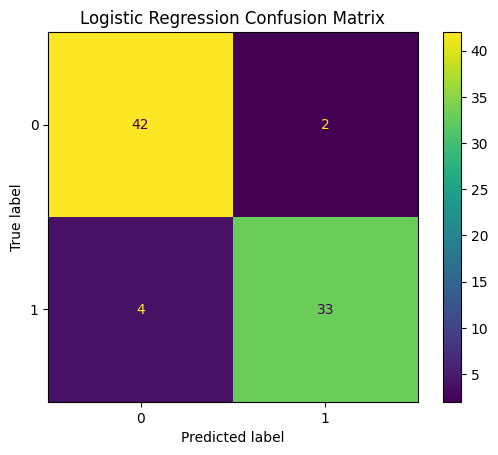


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93        44
           1       0.94      0.89      0.92        37

    accuracy                           0.93        81
   macro avg       0.93      0.92      0.93        81
weighted avg       0.93      0.93      0.93        81



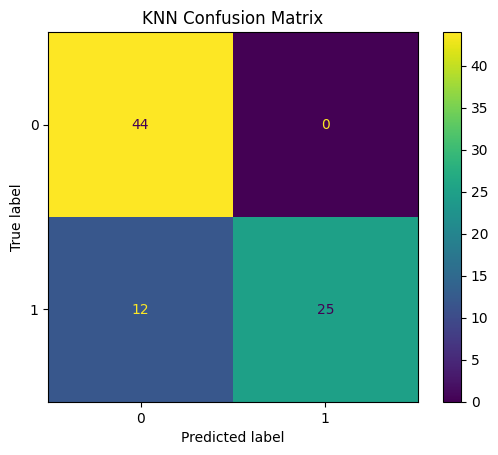


KNN Classification Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88        44
           1       1.00      0.68      0.81        37

    accuracy                           0.85        81
   macro avg       0.89      0.84      0.84        81
weighted avg       0.88      0.85      0.85        81



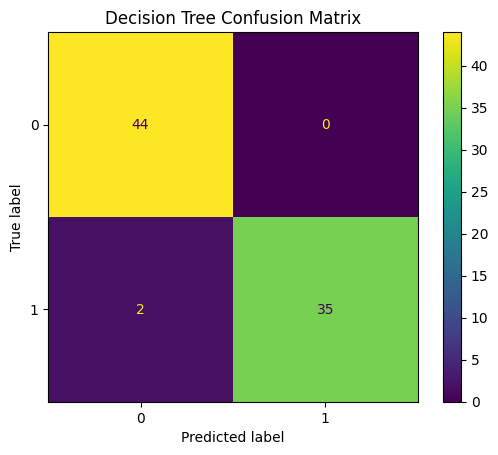


Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        44
           1       1.00      0.95      0.97        37

    accuracy                           0.98        81
   macro avg       0.98      0.97      0.97        81
weighted avg       0.98      0.98      0.98        81



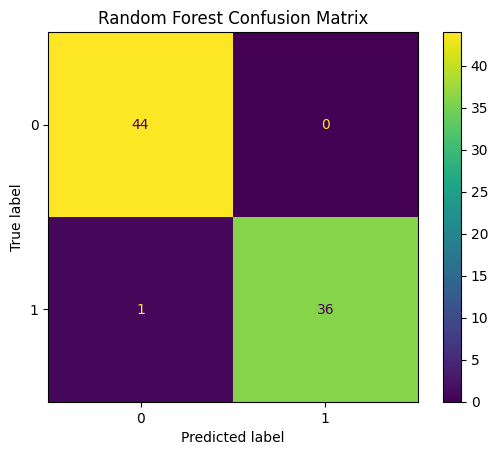


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        44
           1       1.00      0.97      0.99        37

    accuracy                           0.99        81
   macro avg       0.99      0.99      0.99        81
weighted avg       0.99      0.99      0.99        81



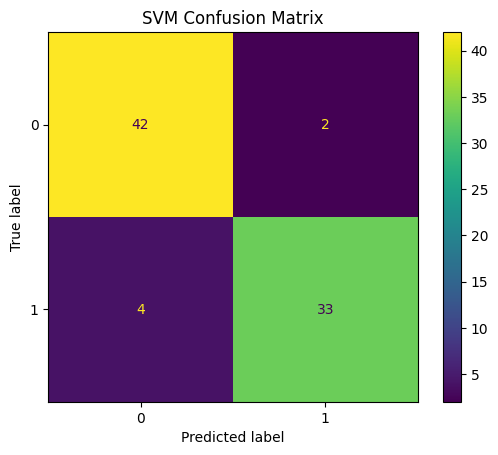


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93        44
           1       0.94      0.89      0.92        37

    accuracy                           0.93        81
   macro avg       0.93      0.92      0.93        81
weighted avg       0.93      0.93      0.93        81



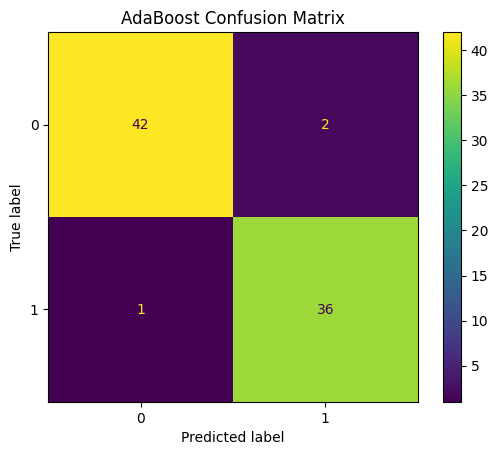


AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97        44
           1       0.95      0.97      0.96        37

    accuracy                           0.96        81
   macro avg       0.96      0.96      0.96        81
weighted avg       0.96      0.96      0.96        81



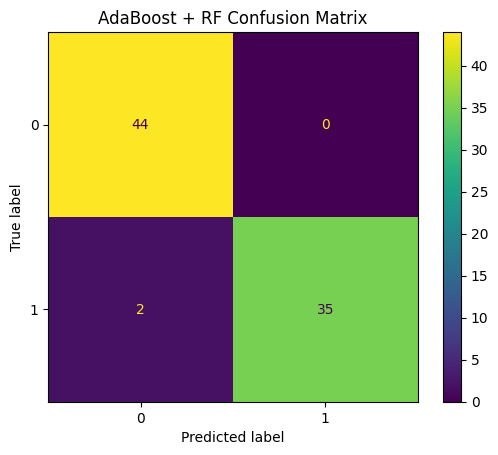


AdaBoost + RF Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        44
           1       1.00      0.95      0.97        37

    accuracy                           0.98        81
   macro avg       0.98      0.97      0.97        81
weighted avg       0.98      0.98      0.98        81



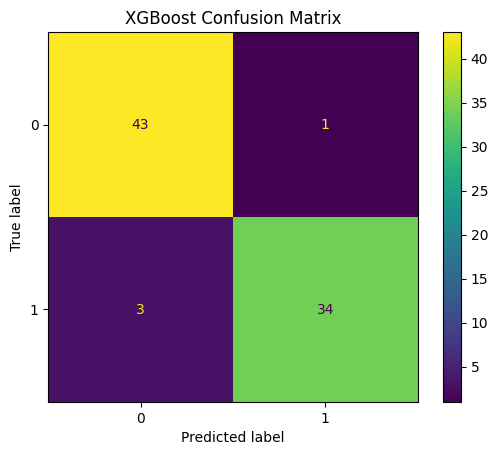


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.96        44
           1       0.97      0.92      0.94        37

    accuracy                           0.95        81
   macro avg       0.95      0.95      0.95        81
weighted avg       0.95      0.95      0.95        81



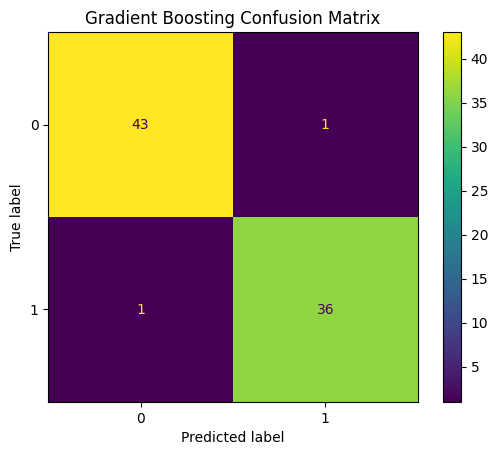


Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        44
           1       0.97      0.97      0.97        37

    accuracy                           0.98        81
   macro avg       0.98      0.98      0.98        81
weighted avg       0.98      0.98      0.98        81



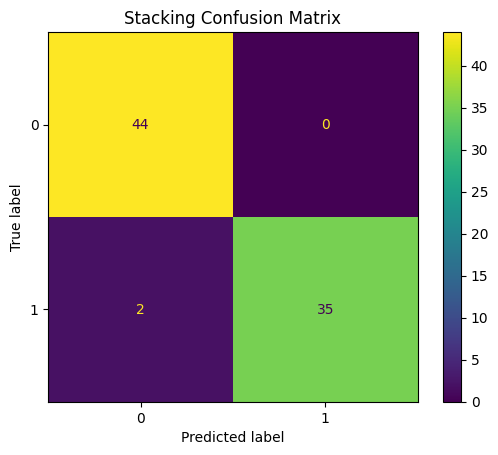


Stacking Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        44
           1       1.00      0.95      0.97        37

    accuracy                           0.98        81
   macro avg       0.98      0.97      0.97        81
weighted avg       0.98      0.98      0.98        81



In [25]:
# Iterate over the models
for name, model in best_models.items():
    # Generate predictions
    y_pred = model.predict(X_test_scaled)

    # Generate the confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    # Print the confusion matrix
    cmd = ConfusionMatrixDisplay(cf_matrix, display_labels=model.classes_)
    cmd.plot()
    plt.title(f'{name} Confusion Matrix')
    plt.show()

    # Generate and print the classification report
    print(f'\n{name} Classification Report:')
    print(classification_report(y_test, y_pred))

### AUC-ROC

In [27]:
from sklearn.metrics import roc_auc_score

# Iterar sobre los modelos
for name, model in best_models.items():
    # Calcular el ROC AUC para las predicciones de la clase positiva
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    
    # Imprimir el resultado
    print(f'{name} AUC-ROC:', roc_auc)


Logistic Regression AUC-ROC: 0.47297297297297297
KNN AUC-ROC: 0.4864864864864865
Decision Tree AUC-ROC: 0.8295454545454546
Random Forest AUC-ROC: 0.9944717444717445
SVM AUC-ROC: 0.47297297297297297
AdaBoost AUC-ROC: 0.9926289926289926
AdaBoost + RF AUC-ROC: 0.5
XGBoost AUC-ROC: 0.6885749385749387
Gradient Boosting AUC-ROC: 0.957923832923833
Stacking AUC-ROC: 0.9794226044226044


Analizando los valores de ROC_AUC RandomForest sigue dando los mejores resultados, estando muy cerca AdaBoost.

## 5. Conclusiones

Basándonos en los resultados de precisión (accuracy) obtenidos, el modelo Random Forest sobresale con la precisión más alta de 0.987. Esto indica que Random Forest tiene el mejor desempeño en términos de precisión de predicción en comparación con los otros modelos evaluados en este estudio. Sin embargo, es esencial tener en cuenta que estos resultados se basan en la validación cruzada y no garantizan necesariamente un rendimiento óptimo en datos no vistos. 